In [334]:
import json 
import glob
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans #The k-means algorithm

## Data Merging

In [335]:
def merge_JsonFiles(): # Merge all data files in to one
    result = list()
    for filename in glob.glob('priv_data/*.json', recursive=False):
        with open(filename, 'r') as infile:
            result.extend(json.load(infile))
    with open('priv_data/combined/combined_matches.json', 'w') as output_file:
        json.dump(result, output_file)
total_matches = merge_JsonFiles()

df = pd.read_json('priv_data/combined/combined_matches.json')

In [336]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 752 entries, 0 to 751
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  752 non-null    int64  
 1   map                 752 non-null    object 
 2   agent               752 non-null    object 
 3   time                752 non-null    object 
 4   mode                752 non-null    object 
 5   score_won           752 non-null    int64  
 6   score_lost          752 non-null    int64  
 7   win                 752 non-null    bool   
 8   placement           752 non-null    int64  
 9   kills               752 non-null    int64  
 10  deaths              752 non-null    int64  
 11  assists             752 non-null    int64  
 12  kd_percentage       752 non-null    float64
 13  hs_percentage       752 non-null    int64  
 14  damage_per_round    752 non-null    int64  
 15  combat_score_total  752 non-null    int64  
 16  username

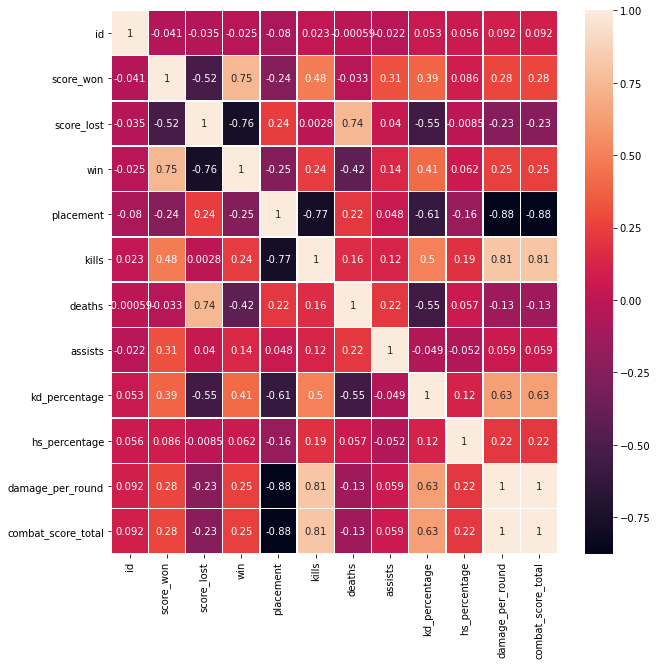

In [337]:
correlation_mat = df.corr()
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(correlation_mat, annot = True, linewidths=.5, ax=ax)
plt.show()

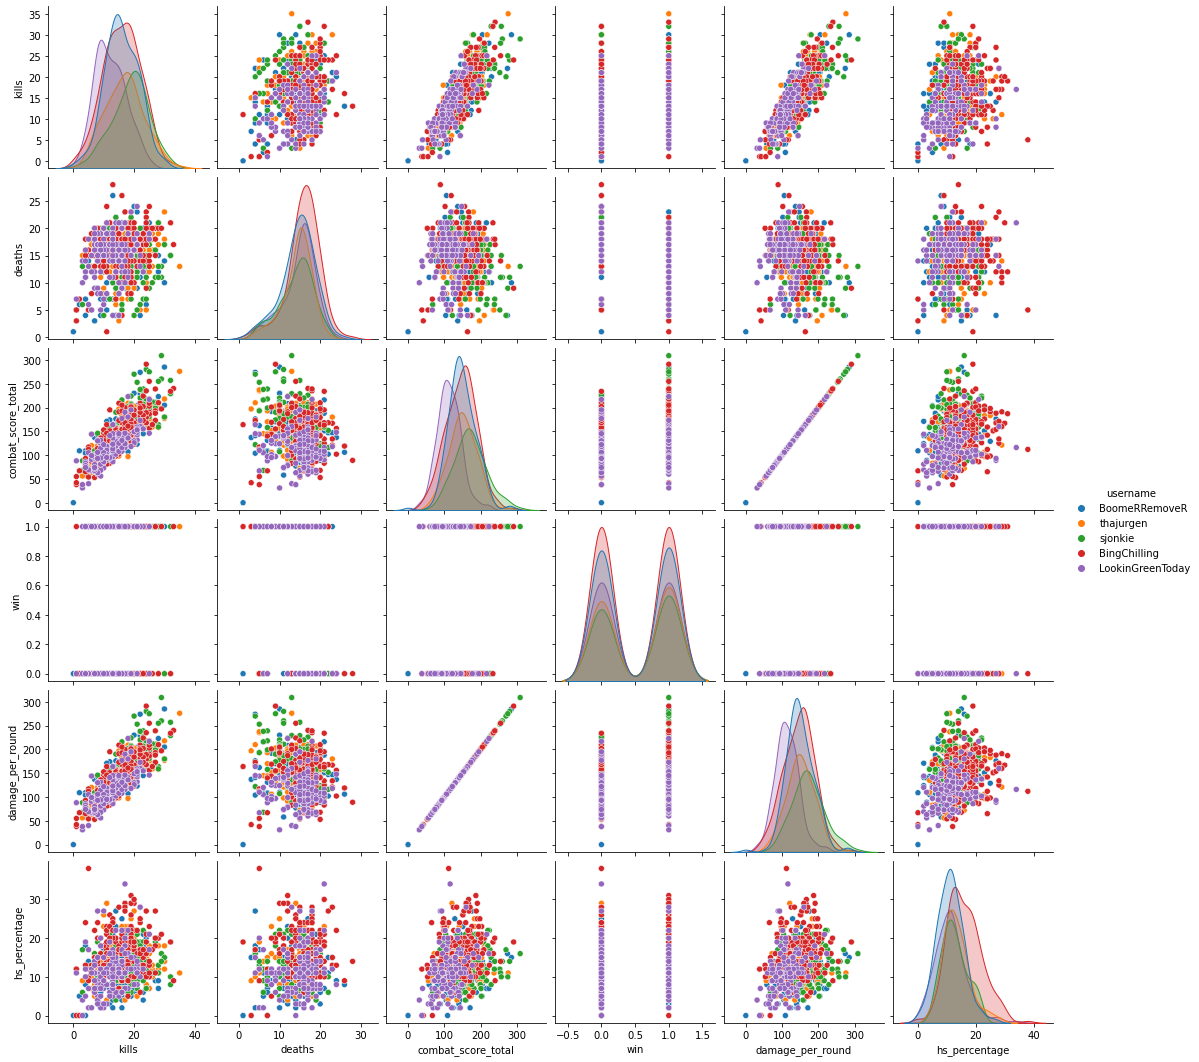

In [338]:
sns.pairplot(data = df[['kills', 'deaths', 'combat_score_total', 'win', 'damage_per_round', 'agent', 'map', 'hs_percentage', 'username']], hue = 'username')

In [339]:
x = df[['hs_percentage']] 
y = df['combat_score_total']
lm = LinearRegression() 
lm.fit(x, y)

b0 = lm.intercept_ #gets the intercept
b1 = lm.coef_[0] #lm.coef_ gets a list of coefficients (excluding the intercept). [0] gets the actual number from the list

print(f"The regression line is equal to y = {b0:.3f} + {b1:.3f}X") #.0f formats to 3 decimals.

The regression line is equal to y = 122.293 + 1.756X


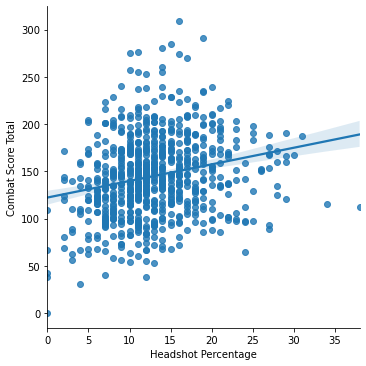

In [340]:
sns.lmplot(x='hs_percentage', y='combat_score_total', data=df)
plt.title('')
plt.xlabel("Headshot Percentage")
plt.ylabel("Combat Score Total")
plt.show()

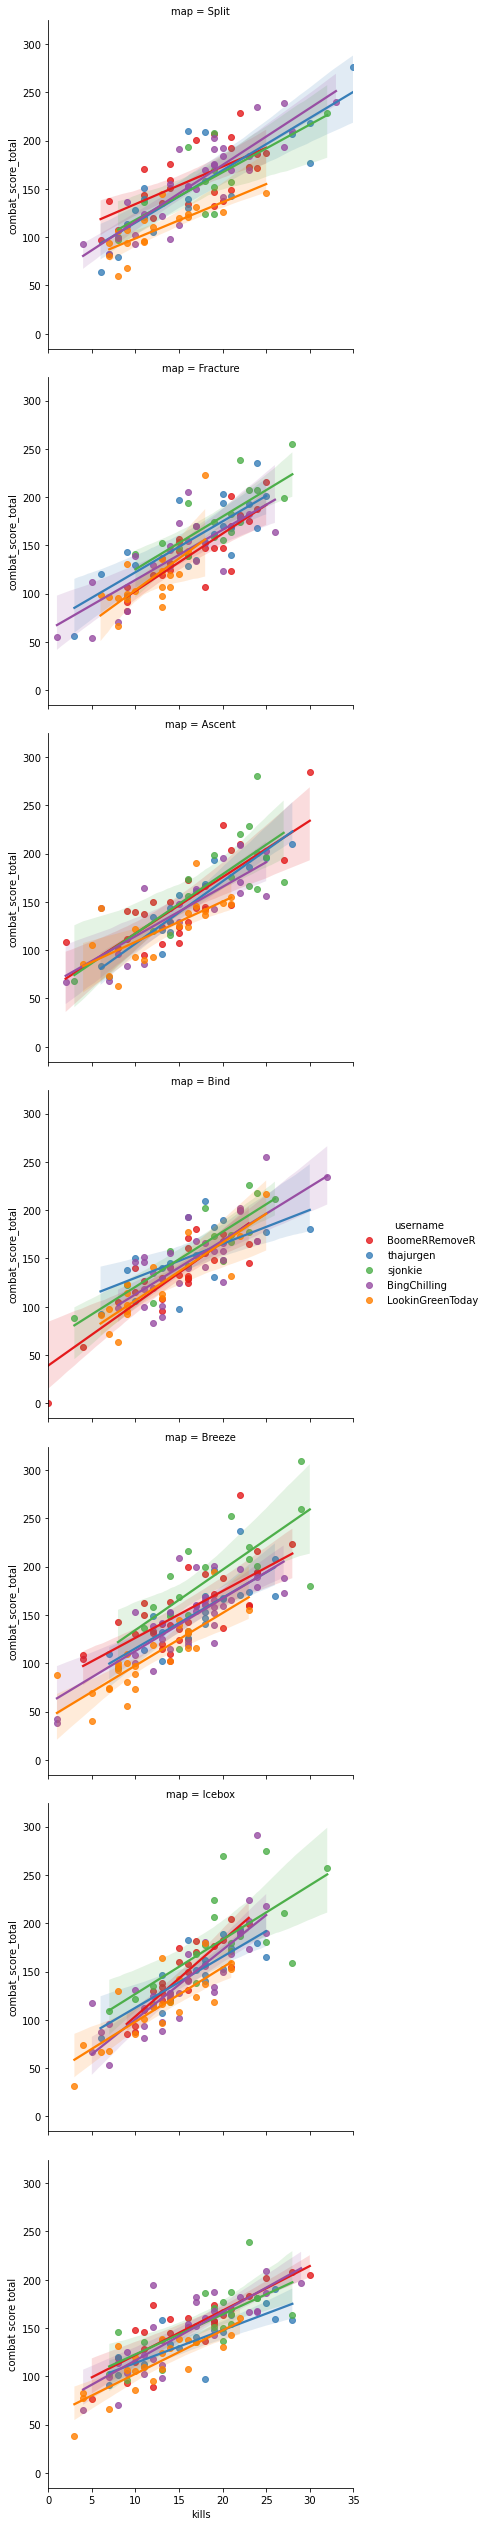

In [341]:
sns.lmplot(
    x='kills',
    y='combat_score_total',
    hue="username",
    palette="Set1",
    row="map",
    data=df
)
plt.title('')
plt.xlabel("kills")
plt.ylabel("combat score total")
plt.show()

In [342]:
df["score_diff"] = df["score_won"] - df["score_lost"]
df.head()

,id,map,agent,time,mode,score_won,score_lost,win,placement,kills,deaths,assists,kd_percentage,hs_percentage,damage_per_round,combat_score_total,username,score_diff
0,1,Split,Brimstone,07:50 PM,Competitive,14,12,True,5,19,22,7,0.9,15,147,147,BoomeRRemoveR,2
1,2,Fracture,Chamber,07:03 PM,Competitive,13,7,True,6,14,9,2,1.6,10,125,125,BoomeRRemoveR,6
2,3,Ascent,Chamber,07:44 PM,Competitive,9,13,False,7,15,20,3,0.8,15,118,118,BoomeRRemoveR,-4
3,4,Bind,Chamber,06:59 PM,Competitive,9,13,False,2,18,16,5,1.1,7,156,156,BoomeRRemoveR,-4
4,5,Breeze,Chamber,06:36 PM,Competitive,13,3,True,3,11,5,1,2.2,17,162,162,BoomeRRemoveR,10


## Random Forest

In [353]:
X = df[['kills', 'deaths', 'assists', 'damage_per_round', 'combat_score_total', 'score_diff', 'hs_percentage', 'kd_percentage']] #This gets all the columns from Time to Amount
y = df['map']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [354]:
rf = RandomForestClassifier(n_estimators=100) #RF is a random algorithm, so to get the same results we need to use random_state
rf = rf.fit(X_train, y_train)

In [355]:
rf.score(X_test,y_test)

0.19911504424778761

In [356]:
rf.predict([[10, 10, 10, 100, 200, 2, 15, 1.0]])

/Users/danielvanderschuur/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array(['Breeze'], dtype=object)

In [357]:
clf=RandomForestClassifier(n_estimators=100)
clf.fit(X_train,y_train)

RandomForestClassifier()

In [358]:
feature_imp = pd.Series(clf.feature_importances_, index=clf.feature_names_in_).sort_values(ascending=False)
feature_imp

hs_percentage         0.140058
damage_per_round      0.139702
combat_score_total    0.138567
score_diff            0.125081
deaths                0.119955
kills                 0.118943
assists               0.113934
kd_percentage         0.103759
dtype: float64

No handles with labels found to put in legend.


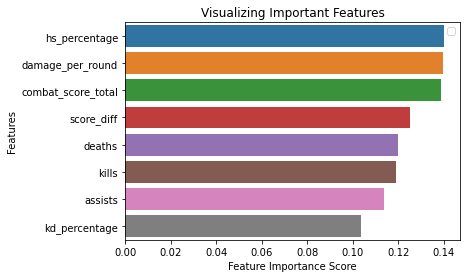

In [359]:
%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

# K-Means

<AxesSubplot:xlabel='hs_percentage', ylabel='combat_score_total'>

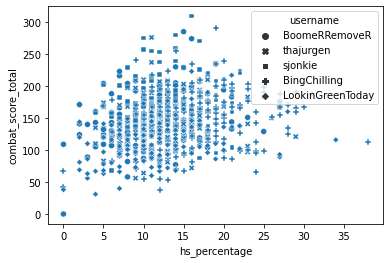

In [350]:
sns.scatterplot(x=df["hs_percentage"], y=df["combat_score_total"], style=df["username"])

<AxesSubplot:xlabel='combat_score_total', ylabel='hs_percentage'>

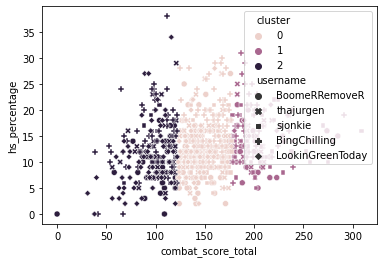

In [351]:
km = KMeans(n_clusters=3) #create a new k-means model with 3 clusters
X = df[['hs_percentage','damage_per_round', 'combat_score_total', 'kills']] #get the X variables from the dataframe
km = km.fit(X) #calculate the cluster centers
df['cluster'] = km.predict(X) #predict the clusters of each observation and store in the dataframe
df.head()

sns.scatterplot(x=df["combat_score_total"], y=df["hs_percentage"], style=df["username"], hue=df["cluster"])


## Predictive Team

In [352]:
df["win"].value_counts()

True     387
False    365
Name: win, dtype: int64